<a href="https://colab.research.google.com/github/jfarr/stable-diffusion-v1/blob/main/stable_diffusion_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Blog](https://huggingface.co/blog/stable_diffusion)

# Configuration

In [ ]:
#@markdown Enter your huggingface access token
YOUR_TOKEN = "" #@param {type:"string"}

#@markdown Enable/disable the NSFW filter. Use at your own risk.
NSFW_FILTER = False #@param {type:"boolean"}

#@markdown Disable FP16 for better results, enable if you're getting out of memory errors.
USE_FP16 = False #@param {type:"boolean"}

# Setup

In [ ]:
!nvidia-smi

Tue Aug 23 07:04:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    37W / 250W |   9457MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install diffusers==0.2.4 transformers scipy ftfy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from datetime import datetime
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


def safe_filename(fname):
    return "".join([c if (c.isalnum() or c == "-") else "_" for c in fname])


def save_images(prompt, grid, images, outdir="output"):

    os.makedirs(outdir, exist_ok=True)
    ts = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

    # save the image files
    image_files = []
    for idx, image in enumerate(images):
        suffix = f"-{ts}-{idx:03}.png"
        fname = safe_filename(prompt[:200 - len(suffix)]) + suffix
        print(f"writing {fname}")
        image.save(os.path.join(outdir, fname))
        image_files.append(fname)

    if len(images) > 1:
        # save the grid file
        suffix = f"-{ts}.png"
        grid_filename = f'grid-{safe_filename(prompt[:195 - len(suffix)])}-{ts}.png'
        print(f"writing {grid_filename}")
        grid.save(os.path.join(outdir, grid_filename))
    else:
        grid_filename = None

    return image_files, grid_filename

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

# get your token at https://huggingface.co/settings/tokens
if USE_FP16:
    pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=YOUR_TOKEN)
else:
    pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", use_auth_token=YOUR_TOKEN)
if not NSFW_FILTER:
    def dummy(images, **kwargs): return images, False 
    pipe.safety_checker = dummy
pipe.to("cuda")

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.2.4",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

# Run

0it [00:00, ?it/s]

writing a_photograph_of_an_astronaut_riding_a_horse-2022-08-23-07-05-09-000.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

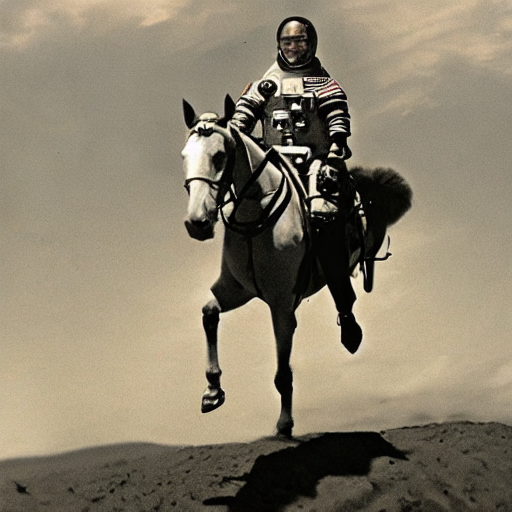

0it [00:00, ?it/s]

writing a_photograph_of_an_astronaut_riding_a_horse-2022-08-23-07-05-27-000.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

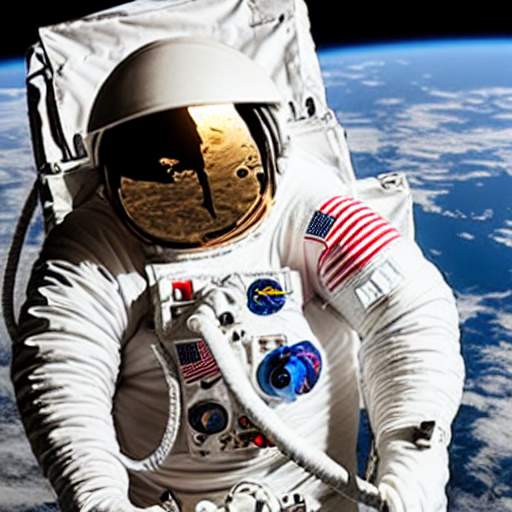

In [ ]:
prompt = "a photograph of an astronaut riding a horse" #@param {type:"string"}

repeat = 2 #@param {type:"integer"}
num_images = 1 #@param {type:"integer"}

from torch import autocast
from IPython.display import display
from google.colab import files

prompts = [prompt] * num_images
for i in range(repeat):
    with autocast("cuda"):
        images = pipe(prompts)["sample"]
    grid = image_grid(images, rows=1, cols=len(images))
    image_files, grid_filename = save_images(prompt, grid, images)
    if grid_filename:
      files.download(os.path.join("output", grid_filename))
    for fname in image_files:
      files.download(os.path.join("output", fname))
    display(grid)